In [7]:
import psycopg2
import os
import requests
import time
import shapely.wkb
import shapely.ops
import sys
import pyproj
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

In [3]:
# setup postgis connecton funcitons
pg_user=os.environ.get('POSTGIS_ENV_POSTGRES_USER')
pg_pass=os.environ.get('POSTGIS_ENV_POSTGRES_PASSWORD')
pg_host=os.environ.get('POSTGIS_PORT_5432_TCP_ADDR')
pg_port=os.environ.get('POSTGIS_PORT_5432_TCP_PORT')

def postgis(query):
    conn = psycopg2.connect(user=pg_user, 
                        password=pg_pass,
                        host=pg_host,
                        port=pg_port
                       )
    cur = conn.cursor()
    cur.execute(query)
    r = list(cur.fetchall())
    cur.close()
    conn.close()
    return r

In [4]:
# setup carto connection funcitons
CARTO_URL = 'https://{}.carto.com/api/v2/sql'
CARTO_USER = 'wri-01'
CARTO_KEY = os.environ.get('CARTO_KEY')

def sendSql(sql, user=None, key=None):
    '''Send arbitrary sql and return response object or False'''
    user = user or CARTO_USER
    key = key or CARTO_KEY
    url = CARTO_URL.format(user)
    payload = {
        'api_key': key,
        'q': sql,
    }
    r = requests.post(url, json=payload)
    if (r.status_code >= 400):
        try:
            msg = r.json()['error'][0]
        except:
            r.raise_for_status()
        raise Exception(msg)
    return r.json()

In [100]:
# shapely + pyproj area calculation
def areaEqual(geom):
    # Equal-area approx equiv to ST_AREA(geog) a la sgilles
    return shapely.ops.transform(
        partial(
            pyproj.transform,
            pyproj.Proj(init='EPSG:4326'),
            pyproj.Proj(
                proj='aea', # Albers equal area
                lat_1=geom.bounds[1],
                lat_2=geom.bounds[3])
        ), geom).area

def loadGeoms(rows, geom_field='the_geom'):
    return [shapely.wkb.loads(r[geom_field], hex=True) for r in rows if r[geom_field]]

# Test simplify tolerances

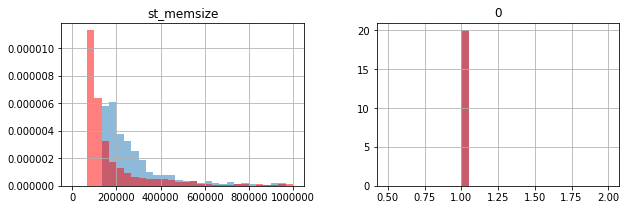

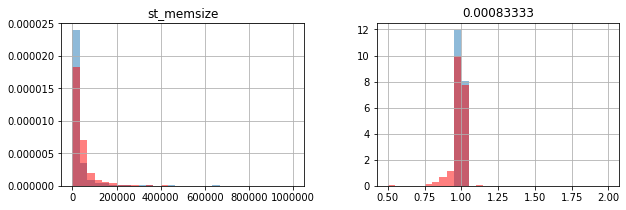

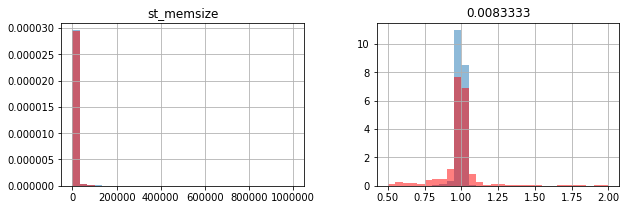

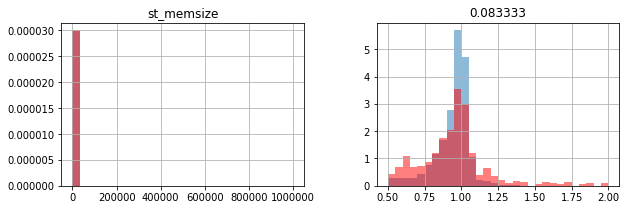

In [90]:
# test simplify tolerances for most complex geoms
tolerances = [0, 
              0.00083333, #3sec ~100m
              0.0083333, #30sec ~1km
              0.083333, #5min ~10km
             ]
base_query = """
select cartodb_id, ST_MEMSIZE({}), ST_AREA({})/ST_AREA(the_geom) as area_err from {} order by ST_MEMSIZE(the_geom) desc limit 1000
"""
gadm_table3 = 'gadm36_adm2'
wdpa_table = 'wdpa_protected_areas'
for t in tolerances:
    if t:
        simp = "ST_SIMPLIFY(the_geom, {})".format(t)
    else:
        simp = 'the_geom'
    
    query = base_query.format(simp, simp, gadm_table3)
    gadm_df=pd.DataFrame(sendSql(query)['rows'])

    query = base_query.format(simp, simp, wdpa_table)
    wdpa_df=pd.DataFrame(sendSql(query)['rows'])

    fig, axs = plt.subplots(1,2, figsize=(10,3))
    gadm_df.hist('st_memsize', range=(0, 1000000), ax=axs[0], alpha=.5, density=True, bins=30)
    wdpa_df.hist('st_memsize', range=(0, 1000000), ax=axs[0], color='r', alpha=.5, density=True, bins=30)
    gadm_df.hist('area_err', range=(.5, 2), ax=axs[1], alpha=.5, density=True, bins=30)
    wdpa_df.hist('area_err', range=(.5, 2), ax=axs[1], color='r', alpha=.5, density=True, bins=30)
    plt.title(t)

# Profile carto queries

In [ ]:
# vars
gadm_table2 = 'gadm36_adm2'
wdpa_table = 'wdpa_protected_areas'

query = """
select cartodb_id, gid_2 from {} where gid_2 in ('USA.2.13_1', 'USA.2.18_1', 'USA.2.2_1')
""".format(gadm_table2)
ids = [r['cartodb_id'] for r in sendSql(query)['rows']]
tolerance = 0.00083333

In [ ]:
# simplify only query polygon
query = """
    EXPLAIN (ANALYZE, FORMAT YAML) (
    SELECT
        ST_INTERSECTION(a.the_geom, b.the_geom) AS the_geom
    FROM {} AS a, (
        SELECT ST_MAKEVALID(ST_SIMPLIFY(the_geom, {tolerance})) AS the_geom
        FROM {} WHERE cartodb_id = {}
    ) AS b
    WHERE st_intersects(a.the_geom, b.the_geom))
""".format(wdpa_table, gadm_table2, ids[0], tolerance=0.000833333)
print(sendSql(query)['rows'][0]['QUERY PLAN'])

In [ ]:
# test only bounding boxes
query = """
    EXPLAIN (ANALYZE, FORMAT YAML) (
    SELECT
        ST_INTERSECTION(
            ST_MAKEVALID(a.the_geom), 
            b.the_geom) AS the_geom
    FROM {} AS a, (
        SELECT ST_MAKEVALID(ST_SIMPLIFY(the_geom, {tolerance})) AS the_geom
        FROM {} WHERE cartodb_id = {}
    ) AS b
    WHERE a.the_geom && b.the_geom)
""".format(wdpa_table, gadm_table2, ids[0], tolerance=0.000833333)
print(sendSql(query)['rows'][0]['QUERY PLAN'])

In [91]:
# simplify both geometries
query = """
    EXPLAIN (ANALYZE, FORMAT YAML) (
    SELECT
        ST_INTERSECTION(
            ST_MAKEVALID(ST_SIMPLIFY(a.the_geom, {tolerance})),
            b.the_geom) AS the_geom
    FROM {} AS a, (
        SELECT ST_MAKEVALID(ST_SIMPLIFY(the_geom, {tolerance})) AS the_geom
        FROM {} WHERE cartodb_id = {}
    ) AS b
    WHERE a.the_geom && b.the_geom)
""".format(wdpa_table, gadm_table2, ids[0], tolerance=0.000833333)
print(sendSql(query)['rows'][0]['QUERY PLAN'])

- Plan: 
    Node Type: "Nested Loop"
    Parallel Aware: false
    Join Type: "Inner"
    Startup Cost: 5.85
    Total Cost: 3524.71
    Plan Rows: 218
    Plan Width: 32
    Actual Startup Time: 3723.233
    Actual Total Time: 8568.030
    Actual Rows: 22
    Actual Loops: 1
    Inner Unique: false
    Plans: 
      - Node Type: "Index Scan"
        Parent Relationship: "Outer"
        Parallel Aware: false
        Scan Direction: "Forward"
        Index Name: "gadm36_adm2_copy_pkey"
        Relation Name: "gadm36_adm2"
        Alias: "gadm36_adm2"
        Startup Cost: 0.29
        Total Cost: 8.31
        Plan Rows: 1
        Plan Width: 18752
        Actual Startup Time: 0.058
        Actual Total Time: 0.061
        Actual Rows: 1
        Actual Loops: 1
        Index Cond: "(cartodb_id = 41007)"
        Rows Removed by Index Recheck: 0
      - Node Type: "Index Scan"
        Parent Relationship: "Inner"
        Parallel Aware: false
        Scan Direction: "NoMovement"
        I

# Profile local union ops

In [93]:
# test geoms for local union
test_geoms = []
for cdbid in ids:
    query = """
        SELECT
            ST_INTERSECTION(
                ST_MAKEVALID(ST_SIMPLIFY(a.the_geom, {tolerance})),
                b.the_geom) AS the_geom
        FROM {} AS a, (
            SELECT ST_MAKEVALID(ST_SIMPLIFY(the_geom, {tolerance})) AS the_geom
            FROM {} WHERE cartodb_id = {}
        ) AS b
        WHERE a.the_geom && b.the_geom
    """.format(wdpa_table, gadm_table2, cdbid, tolerance=tolerance)
    test_geoms.append( sendSql(query)['rows'] )

In [106]:
%%timeit -r 3 -n 1
## Profile union+area local postgis
for rows in test_geoms:
    geoms = ','.join(["'{}'::geometry".format(r['the_geom']) for r in rows if r['the_geom']])
    query = """
    SELECT ST_AREA(ST_UNION(ARRAY[{}])::geography) as area
    """.format(geoms)
    area = postgis(query)[0][0]

165 ms ± 19.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [107]:
%%timeit -r 3 -n 1
## Profile union+area shapely + pyproj
for rows in test_geoms:
    geoms = loadGeoms(rows)
    union_geoms = shapely.ops.cascaded_union(geoms)
    area = areaEqual(union_geoms)

843 ms ± 16.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


# Etc...

,cartodb_id,gid_2,st_memsize
17,5568,BRA.15.220_1,528
27,5567,BRA.15.219_1,560
7,5563,BRA.15.215_1,576
18,5624,BRA.16.55_1,1472
20,25441,NGA.12.4_1,1504
19,15299,GTM.7.30_1,1744
16,14801,GBR.4.17_1,3312
26,14470,FRA.1.10_1,6576
24,16972,IDN.14.7_1,9280
25,16978,IDN.14.13_1,17376


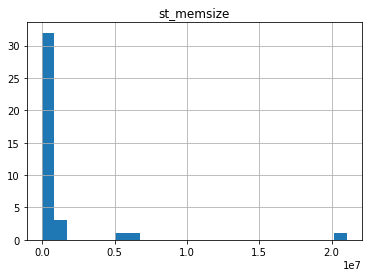

In [12]:
gadm_table3 = 'gadm36_adm2'
query = """
select cartodb_id, gid_2, ST_MEMSIZE(the_geom) from {} where gid_2 in ('AUS.11.137_1',
 'BEL.3.3_1',
 'BRA.15.215_1',
 'BRA.15.219_1',
 'BRA.15.220_1',
 'BRA.16.55_1',
 'CAN.8.1_1',
 'CAN.8.3_1',
 'CAN.11.84_1',
 'DEU.4.18_1',
 'DEU.8.1_1',
 'DEU.8.2_1',
 'DEU.10.13_1',
 'DEU.10.21_1',
 'DEU.10.27_1',
 'DEU.10.43_1',
 'DEU.14.11_1',
 'DNK.2.3_1',
 'DNK.3.3_1',
 'DNK.3.4_1',
 'DNK.5.19_1',
 'ESP.3.1_1',
 'ESP.6.3_1',
 'ESP.11.1_1',
 'ESP.11.2_1',
 'ESP.14.2_1',
 'FIN.2.1_1',
 'FIN.5.3_1',
 'FRA.1.10_1',
 'FRA.10.11_1',
 'GBR.1.22_1',
 'GBR.3.4_1',
 'GBR.3.17_1',
 'GBR.4.17_1',
 'GTM.7.30_1',
 'IDN.14.7_1',
 'IDN.14.13_1',
 'NGA.12.4_1')
""".format(gadm_table3)
df=pd.DataFrame(sendSql(query)['rows'])
df.hist('st_memsize', bins=25)
df.sort_values('st_memsize')